In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('DATASETS/NumericalSummaryOnly/Ravdess_TRAIN_transformed.csv')
df_test=pd.read_csv('DATASETS/NumericalSummaryOnly/Ravdess_TEST_transformed.csv')

# Prepare the dataset

In [4]:
#remapping
emotion_demapper = {1:"neutral", 2:"calm", 3:"happy", 4:"sad", 5:"angry", 6:"fearful", 7:"disgust", 8:"surprised"}
df["emotion"] = df["emotion"].replace(emotion_demapper)
df_test["emotion"] = df_test["emotion"].replace(emotion_demapper)

emotion_mapper = {"neutral":0, "calm":0, "happy":0, "sad":0, "angry":0, "fearful":0, "disgust":0, "surprised":1}
df["emotion"] = df["emotion"].replace(emotion_mapper)
df_test["emotion"] = df_test["emotion"].replace(emotion_mapper)

In [5]:
X, y = df.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df[["emotion"]].values.flatten()
X2, y2 = df_test.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df_test[["emotion"]].values.flatten()

X_train, y_train = X, y
X_test, y_test = X2, y2

In [ ]:
from imblearn.over_sampling import SVMSMOTE
svmsmote = SVMSMOTE(random_state=40)
X_resampled, y_resampled = svmsmote.fit_resample(X_train, y_train)

In [6]:
from scipy.sparse import csr_matrix

# create a sparse CSR matrix from the feature matrix
X_sparse = csr_matrix(df.iloc[:, 7:].values)

# calculate the sparsity of the feature matrix
sparsity = 1.0 - (X_sparse.nnz / float(X_sparse.shape[0] * X_sparse.shape[1]))

print("Sparsity: {:.2%}".format(sparsity))

Sparsity: 7.63%


# Logistic Regression

In [9]:
#simple application
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report,  matthews_corrcoef


clf = LogisticRegression(random_state=0, max_iter=2000, solver='liblinear', penalty='l2', C=0.5)
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(X_test)

mcc = matthews_corrcoef(y_test, y_pred)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print("Matthews'coefficient", mcc)
print(classification_report(y_test, y_pred))

NameError: name 'X_resampled' is not defined

Good hyperparameters in term of overfitting and accuracy:
- solver: liblinear
- penalty: l2 (Ridge)
- C: 0.5

In [8]:
clf = LogisticRegression(random_state=0, max_iter=2000, solver='liblinear', penalty='l1', C=1)
clf.fit(X_resampled, y_resampled)

#Retrieve the coefficients of Logistic
coef = clf.coef_

#Features with zero coefficients (or very close to 0)
zero_coef_indices = np.where(np.abs(coef) < 1e-6)[1]
removed_features = X_resampled.iloc[:, zero_coef_indices].columns.tolist()

print("Features removed by Lasso regularization with logistic regression:")
print(removed_features)

print("Indices removed:", zero_coef_indices)

Features removed by Lasso regularization with logistic regression:
['q50', 'q75', 'lag1_q25', 'lag1_q75', 'zc_sum', 'zc_std', 'mfcc_mean', 'mfcc_skew', 'sc_sum', 'sc_mean', 'sc_q75', 'sc_q95', 'stft_sum', 'stft_q01', 'stft_q25', 'stft_q50', 'stft_q75', 'stft_kur', 'min_w1', 'q01_w1', 'q05_w1', 'q50_w1', 'lag1_std_w1', 'lag1_max_w1', 'lag1_q25_w1', 'lag1_q99_w1', 'zc_sum_w1', 'mfcc_std_w1', 'mfcc_q50_w1', 'mfcc_kur_w1', 'sc_sum_w1', 'sc_mean_w1', 'sc_std_w1', 'sc_min_w1', 'sc_max_w1', 'sc_q05_w1', 'sc_q25_w1', 'sc_q95_w1', 'stft_mean_w1', 'stft_max_w1', 'stft_q05_w1', 'stft_q25_w1', 'stft_q50_w1', 'stft_q75_w1', 'stft_q95_w1', 'stft_q99_w1', 'q50_w2', 'q75_w2', 'lag1_q75_w2', 'zc_sum_w2', 'mfcc_mean_w2', 'mfcc_std_w2', 'mfcc_min_w2', 'mfcc_q75_w2', 'mfcc_q99_w2', 'mfcc_skew_w2', 'sc_mean_w2', 'sc_min_w2', 'sc_q01_w2', 'sc_q75_w2', 'sc_q95_w2', 'sc_q99_w2', 'stft_sum_w2', 'stft_std_w2', 'stft_q50_w2', 'max_w3', 'q75_w3', 'q99_w3', 'lag1_q75_w3', 'lag1_skew_w3', 'zc_std_w3', 'mfcc_sum_w3'

# RandomForest/AdaBoost with zero-coefficients removed

In [9]:
#removing useless features (according to Lasso coefficients)
df_clean = df.drop(zero_coef_indices)
df_test_clean = df_test.drop(zero_coef_indices)
X_train_clean, y_train_clean = df_clean.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df_clean[["emotion"]].values.flatten()
X_test_clean, y_test_clean = df_test_clean.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df_test_clean[["emotion"]].values.flatten()
svmsmote = SVMSMOTE(random_state=40)
X_resampled_clean, y_resampled_clean = svmsmote.fit_resample(X_train_clean, y_train_clean)

### RandomForest

In [10]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=350, 
                             criterion='gini', 
                             max_depth=8, 
                             min_samples_split=8, 
                             min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=5, 
                             n_jobs=-1)

clf.fit(X_resampled_clean, y_resampled_clean)

y_pred = clf.predict(X_test_clean)

mcc = matthews_corrcoef(y_test_clean, y_pred)

print('Accuracy %s' % accuracy_score(y_test_clean, y_pred))
print('F1-score %s' % f1_score(y_test_clean, y_pred, average=None))
print("Matthews'coefficient ", mcc)
print(classification_report(y_test_clean, y_pred))

Accuracy 0.9063745019920318
F1-score [0.94840834 0.49462366]
Matthews'coefficient  0.4570298846998379
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       465
           1       0.41      0.62      0.49        37

    accuracy                           0.91       502
   macro avg       0.69      0.78      0.72       502
weighted avg       0.93      0.91      0.91       502



### AdaBoost

In [11]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=300, random_state=42)
clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8990384615384616
F1-score [0.94459103 0.43243243]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       576
           1       0.38      0.50      0.43        48

    accuracy                           0.90       624
   macro avg       0.67      0.72      0.69       624
weighted avg       0.91      0.90      0.91       624



### Showing the difference in Random Forest all_features vs removed_features varying the number of estimators

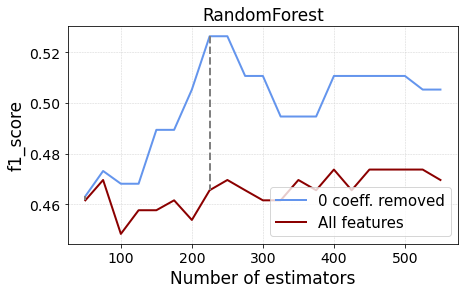

In [33]:
n_estimators = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550]

f1_scores_0_coeffs = []
f1_scores = []

for n in n_estimators:
    clf = RandomForestClassifier(n_estimators=n, 
                             criterion='gini', 
                             max_depth=8, 
                             min_samples_split=8, 
                             min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=5, 
                             n_jobs=-1)
    
    clf.fit(X_resampled_clean, y_resampled_clean)
    y_pred = clf.predict(X_test_clean)
    f1_scores_0_coeffs.append(f1_score(y_test_clean, y_pred, average=None)[1])
    
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average=None)[1])
    
# Find the indices of the minimum and maximum differences
diffs = np.array(f1_scores) - np.array(f1_scores_0_coeffs)
min_diff_idx = np.argmin(diffs)
max_diff_idx = np.argmax(diffs)

# Find the x and y values of the minimum and maximum differences
min_diff_x = n_estimators[min_diff_idx]
min_diff_y1 = f1_scores_0_coeffs[min_diff_idx]
min_diff_y2 = f1_scores[min_diff_idx]

max_diff_x = n_estimators[max_diff_idx]
max_diff_y1 = f1_scores_0_coeffs[max_diff_idx]
max_diff_y2 = f1_scores[max_diff_idx]
    

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(n_estimators, f1_scores_0_coeffs, label='0 coeff. removed', color='cornflowerblue', linewidth=2)
ax.plot(n_estimators, f1_scores, label='All features', color='darkred', linewidth=2) 

ax.plot([min_diff_x, min_diff_x], [min_diff_y1, min_diff_y2], color='grey', linestyle='--', linewidth=2)
ax.plot([max_diff_x, max_diff_x], [max_diff_y1, max_diff_y2], color='grey', linestyle='--', linewidth=2)


ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)

ax.set_xlabel('Number of estimators', fontsize=17)
ax.set_ylabel('f1_score', fontsize=17)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=15, loc='lower right')
plt.title("RandomForest", fontsize=17)
plt.show()


### Showing the difference in AdaBoost all_features vs removed_features varying the number of estimators

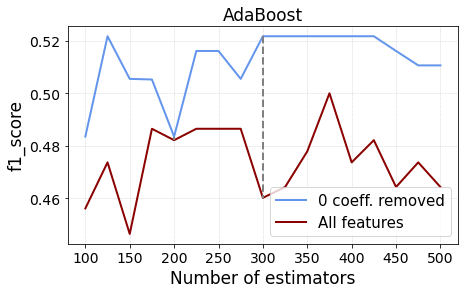

In [38]:
n_estimators = [100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500]

f1_scores_0_coeffs = []
f1_scores = []

clf = RandomForestClassifier(n_estimators=350, #350 good
                             criterion='gini', 
                             max_depth=8, 
                             min_samples_split=8, 
                             min_samples_leaf=2, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=7, 
                             n_jobs=-1)
    

for n in n_estimators:    
    clf_ada = AdaBoostClassifier(base_estimator=clf, n_estimators=n)

    clf_ada.fit(X_resampled_clean, y_resampled_clean)
    y_pred = clf_ada.predict(X_test_clean)
    f1_scores_0_coeffs.append(f1_score(y_test_clean, y_pred, average=None)[1])
    
    clf_ada.fit(X_resampled, y_resampled)
    y_pred = clf_ada.predict(X_test)
    f1_scores.append(f1_score(y_test, y_pred, average=None)[1])
    
# Find the indices of the minimum and maximum differences
diffs = np.array(f1_scores) - np.array(f1_scores_0_coeffs)
min_diff_idx = np.argmin(diffs)
max_diff_idx = np.argmax(diffs)

# Find the x and y values of the minimum and maximum differences
min_diff_x = n_estimators[min_diff_idx]
min_diff_y1 = f1_scores_0_coeffs[min_diff_idx]
min_diff_y2 = f1_scores[min_diff_idx]

max_diff_x = n_estimators[max_diff_idx]
max_diff_y1 = f1_scores_0_coeffs[max_diff_idx]
max_diff_y2 = f1_scores[max_diff_idx]
    

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(n_estimators, f1_scores_0_coeffs, label='0 coeff. removed', color='cornflowerblue', linewidth=2)
ax.plot(n_estimators, f1_scores, label='All features', color='darkred', linewidth=2) 

ax.plot([min_diff_x, min_diff_x], [min_diff_y1, min_diff_y2], color='grey', linestyle='--', linewidth=2)
ax.plot([max_diff_x, max_diff_x], [max_diff_y1, max_diff_y2], color='grey', linestyle='--', linewidth=2)

ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)

ax.set_xlabel('Number of estimators', fontsize=17)
ax.set_ylabel('f1_score', fontsize=17)
ax.tick_params(axis='both', labelsize=14)
ax.legend(fontsize=15, loc='lower right')
plt.title("AdaBoost", fontsize=17)
plt.show()

## Show the difference in terms of overfitting between Lasso and Ridge

In [39]:
from sklearn.model_selection import train_test_split

X, y = df.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df[["emotion"]].values.flatten()
X2, y2 = df_test.drop(["emotion", "vocal_channel", "emotional_intensity", "statement", "repetition", "actor", "sex"], axis=1), df_test[["emotion"]].values.flatten()

X_resampled, y_resampled = svmsmote.fit_resample(X, y)

#X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train, y_train = X_resampled, y_resampled
X_val, y_val = X2, y2


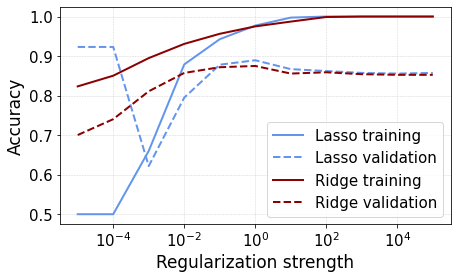

In [40]:
train_acc_l1 = []
val_acc_l1 = []
train_acc_l2 = []
val_acc_l2 = []

C_vals = np.logspace(-5, 5, 11) #0.0001, 0.001, 0.01, 0.1, 1, 10, 100
#C_vals=[0.1, 1]

for C in C_vals:
    # L1 regularization
    log_reg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=2000)
    log_reg_l1.fit(X_train, y_train)
    train_acc_l1.append(log_reg_l1.score(X_train, y_train))
    val_acc_l1.append(log_reg_l1.score(X_val, y_val))
    
    # L2 regularization
    log_reg_l2 = LogisticRegression(penalty='l2', C=C, solver='liblinear', max_iter=2000)
    log_reg_l2.fit(X_train, y_train)
    train_acc_l2.append(log_reg_l2.score(X_train, y_train))
    val_acc_l2.append(log_reg_l2.score(X_val, y_val))
    
# Plot the training and validation accuracy as a function of the regularization strength
fig, ax = plt.subplots(figsize=(7, 4))

ax.semilogx(C_vals, train_acc_l1, label='Lasso training', color='cornflowerblue', linewidth=2) #l1
ax.semilogx(C_vals, val_acc_l1, label='Lasso validation', color='cornflowerblue', linestyle='--', linewidth=2) #l1
ax.semilogx(C_vals, train_acc_l2, label='Ridge training', color='darkred', linewidth=2) #l2
ax.semilogx(C_vals, val_acc_l2, label='Ridge validation', color='darkred', linestyle='--', linewidth=2) #l2
ax.set_xlabel('Regularization strength', fontsize=17)
ax.set_ylabel('Accuracy', fontsize=17)

ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)

ax.tick_params(axis='both', labelsize=15)
ax.legend(fontsize=14, loc="lower right")
plt.show()

In [1]:
'''
train_mcc_l1 = []
val_mcc_l1 = []
train_mcc_l2 = []
val_mcc_l2 = []

C_vals = np.logspace(-5, 5, 11) #0.0001, 0.001, 0.01, 0.1, 1, 10, 100
#C_vals=[0.1, 1]

clf.fit(X_resampled, y_resampled)

y_pred = clf.predict(X_test)

mcc = matthews_corrcoef(y_test, y_pred)

for C in C_vals:
    # L1 regularization
    log_reg_l1 = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000)
    log_reg_l1.fit(X_train, y_train)
    train_mcc_l1.append(matthews_corrcoef(y_train, log_reg_l1.predict(X_train)))
    val_mcc_l1.append(matthews_corrcoef(y_val, log_reg_l1.predict(X_val)))
    
    # L2 regularization
    log_reg_l2 = LogisticRegression(penalty='l2', C=C, solver='liblinear', max_iter=1000)
    log_reg_l2.fit(X_train, y_train)
    train_mcc_l2.append(matthews_corrcoef(y_train, log_reg_l2.predict(X_train)))
    val_mcc_l2.append(matthews_corrcoef(y_val, log_reg_l2.predict(X_val)))
'''
    
# Plot the training and validation accuracy as a function of the regularization strength
fig, ax = plt.subplots(figsize=(7, 4))

ax.semilogx(C_vals, train_mcc_l1, label='Lasso training', color='cornflowerblue', linewidth=2) #l1
ax.semilogx(C_vals, val_mcc_l1, label='Lasso validation', color='cornflowerblue', linestyle='--', linewidth=2) #l1
ax.semilogx(C_vals, train_mcc_l2, label='Ridge training', color='darkred', linewidth=2) #l2
ax.semilogx(C_vals, val_mcc_l2, label='Ridge validation', color='darkred', linestyle='--', linewidth=2) #l2
ax.set_xlabel('Regularization strength', fontsize=17)
ax.set_ylabel('MCC', fontsize=17)
ax.tick_params(axis='both', labelsize=15)

ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
ax.legend(fontsize=15, loc="lower right")
plt.show()

NameError: name 'plt' is not defined

# Neural Network

In [6]:
class_counts = df['emotional_intensity'].value_counts() #0 normal, 1 strong

#95%, 5%
num_to_remove = int(class_counts[1] - class_counts[0]*0.1/0.9)

#random remove
remove_indices = np.random.choice(df[df['emotional_intensity'] == 1].index, num_to_remove, replace=False)

# remove the selected records
df_task = df.drop(remove_indices)

df_task['emotional_intensity'].value_counts()

0    984
1    110
Name: emotional_intensity, dtype: int64

In [7]:
X, y = df.drop(["emotion", "vocal_channel", "sex", "statement", "repetition", "actor"], axis=1), df[["emotional_intensity"]].values.flatten()
X2, y2 = df_test.drop(["emotion", "vocal_channel", "sex", "statement", "repetition", "actor"], axis=1), df_test[["emotional_intensity"]].values.flatten()

X_train, y_train = X, y
X_test, y_test = X2, y2

In [8]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=0, solver="sgd", validation_fraction=0.35, early_stopping=True)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print("Matthews'coefficient ", mcc)
print(classification_report(y_test, y_pred))

NameError: name 'matthews_corrcoef' is not defined

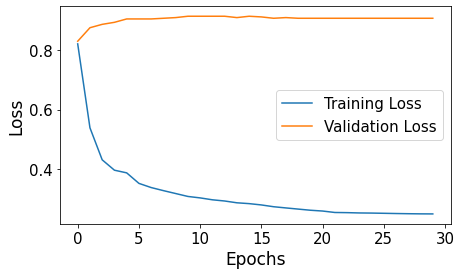

In [28]:
training_loss_curve = clf.loss_curve_
validation_loss_curve = clf.validation_scores_

# Plot the loss function over time for both the training and validation sets
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(training_loss_curve, label='Training Loss')
plt.plot(validation_loss_curve, label='Validation Loss')
plt.xlabel('Epochs', fontsize=17)
plt.ylabel('Loss', fontsize=17)
ax.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)
plt.show()

### Neural Network Hyperparameter Tuning

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#solver

# three different solver
lbfgs_mlp = MLPClassifier(solver='lbfgs')
sgd_mlp = MLPClassifier(solver='sgd', max_iter=1000)
adam_mlp = MLPClassifier(solver='adam')

# Train
lbfgs_mlp.fit(X_train, y_train)
sgd_mlp.fit(X_train, y_train)
adam_mlp.fit(X_train, y_train)

# Predict
lbfgs_pred = lbfgs_mlp.predict(X_test)
sgd_pred = sgd_mlp.predict(X_test)
adam_pred = adam_mlp.predict(X_test)

# matthew's coefficient
mcc_lbfgs = matthews_corrcoef(y_test, lbfgs_pred)
mcc_sgd = matthews_corrcoef(y_test, sgd_pred)
mcc_adam = matthews_corrcoef(y_test, adam_pred)

# Print
print("LBFGS MLPClassifier results")
print(classification_report(y_test, lbfgs_pred))
print("Matthew's coefficient:", mcc_lbfgs)
print("---------------------------------------")

print("SGD MLPClassifier results")
print(classification_report(y_test, sgd_pred))
print("Matthew's coefficient:", mcc_sgd)
print("---------------------------------------")

print("Adam MLPClassifier results")
print(classification_report(y_test, adam_pred))
print("Matthew's coefficient:", mcc_adam)

LBFGS MLPClassifier results
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       336
           1       0.86      0.93      0.89       288

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624

Matthew's coefficient: 0.7997437561571867
---------------------------------------
SGD MLPClassifier results
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       336
           1       0.95      0.90      0.92       288

    accuracy                           0.93       624
   macro avg       0.93      0.93      0.93       624
weighted avg       0.93      0.93      0.93       624

Matthew's coefficient: 0.8616728268499805
---------------------------------------
Adam MLPClassifier results
              precision    recall  f1-score   support

           0       0.92      0.89      0.90   

### GridSearch

In [32]:
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(8), (16), (32), (64)],
    'activation': ['tanh', 'logistic', 'relu'],
    'solver': ['sgd'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'batch_size': [30, 70, 100, 150],
    'validation_fraction': [0.35],
    'early_stopping': [True],
    #'max_iter':[20, 50, 100, 150, 200, 500, 1000] do later for overfitting evaluation
}


grid_search = GridSearchCV(mlp, param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1')
grid_search.fit(X_train, y_train)


print("Best hyperparameters: ", grid_search.best_params_)
print("Best f1 score: ", grid_search.best_score_)

Best hyperparameters:  {'activation': 'tanh', 'alpha': 1, 'batch_size': 70, 'early_stopping': True, 'hidden_layer_sizes': 8, 'learning_rate': 'constant', 'solver': 'sgd', 'validation_fraction': 0.35}
Best f1 score:  0.9580443457105492


### Tuning hyperparameter starting from the ones GridSearch returned (minimize overfitting)

In [15]:

mlp = MLPClassifier(activation='tanh', alpha=1, batch_size=70, early_stopping=True,
                    hidden_layer_sizes=(8), learning_rate='constant',  solver='sgd', validation_fraction=0.35,
                   random_state=0)

#mlp = MLPClassifier()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print("Matthews'coefficient ", mcc)
print(classification_report(y_test, y_pred))

Accuracy 0.8974358974358975
F1-score [0.90153846 0.89297659]
Matthews'coefficient  0.7967557828534078
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       336
           1       0.86      0.93      0.89       288

    accuracy                           0.90       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



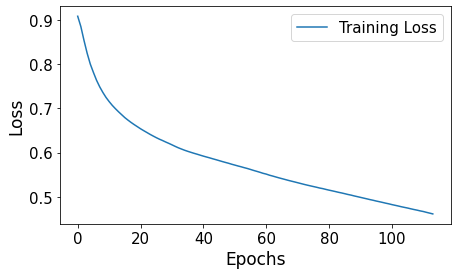

In [67]:
training_loss_curve = mlp.loss_curve_

# Plot the loss function over time for both the training and validation sets
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(training_loss_curve, label='Training Loss')
plt.xlabel('Epochs', fontsize=17)
plt.ylabel('Loss', fontsize=17)
ax.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15)
plt.show()

### Accuracy and Overfitting as the hidden_layer varies

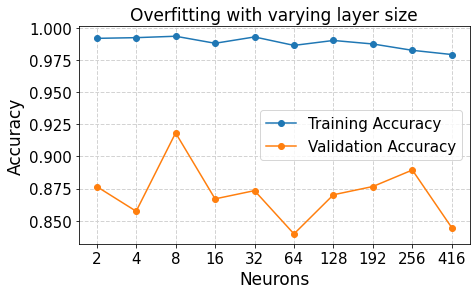

In [108]:
X_val, y_val = X_test, y_test

#hidden layers to try
hidden_layer_sizes = [(2), (4), (8), (16), (32), (64), (128), (192), (256), (416)]
hidden_layer_sizes_label = ["2", "4", "8", "16", "32", "64", "128", "192", "256", "416"]

train_acc = []
val_acc = []

for size in hidden_layer_sizes:
    mlp = MLPClassifier(activation='tanh', alpha=1, batch_size=70, early_stopping=True,
                    hidden_layer_sizes=size, learning_rate='constant',  solver='sgd', validation_fraction=0.35, random_state=42)
    mlp.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, mlp.predict(X_train)))
    val_acc.append(accuracy_score(y_val, mlp.predict(X_val)))

#Plot
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(hidden_layer_sizes_label, train_acc, '-o', label='Training Accuracy')
plt.plot(hidden_layer_sizes_label, val_acc, '-o', label='Validation Accuracy')
plt.xlabel('Neurons', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.title('Overfitting with varying layer size', fontsize=17)
ax.tick_params(axis='both', labelsize=15)
ax.grid(color='lightgrey', linestyle='--', linewidth=1)
plt.legend(fontsize=15)
plt.show()

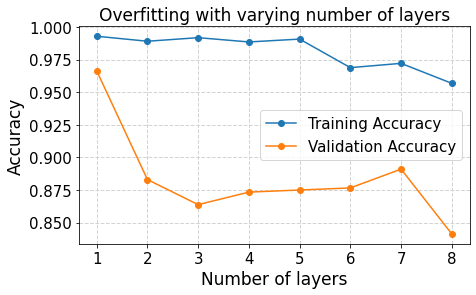

In [109]:
X_val, y_val = X_test, y_test

#hidden layers to try
hidden_layer_sizes = [(8), (8, 8), (8, 8, 8), (8, 8, 8, 8), (8, 8, 8, 8, 8), (8, 8, 8, 8, 4), (8, 8, 8, 8, 8, 8, 8), (8 ,8 ,8 ,8, 8, 8, 8, 8)]
hidden_layer_sizes_label = ["1", "2", "3", "4", "5", "6", "7", "8"] 

train_acc = []
val_acc = []

for size in hidden_layer_sizes:
    mlp = MLPClassifier(activation='tanh', alpha=1, batch_size=70, early_stopping=True,
                    hidden_layer_sizes=size, learning_rate='constant',  solver='sgd', validation_fraction=0.35, random_state=30)
    mlp.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, mlp.predict(X_train)))
    val_acc.append(accuracy_score(y_val, mlp.predict(X_val)))

#Plot
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(hidden_layer_sizes_label, train_acc, '-o', label='Training Accuracy')
plt.plot(hidden_layer_sizes_label, val_acc, '-o', label='Validation Accuracy')
plt.xlabel('Number of layers', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.title('Overfitting with varying number of layers', fontsize=17)
ax.tick_params(axis='both', labelsize=15)
ax.grid(color='lightgrey', linestyle='--', linewidth=1)
plt.legend(fontsize=15)
plt.show()

### Accuracy and Overfitting as the number of epochs varies

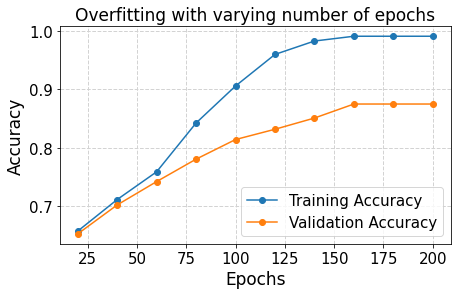

In [96]:
X_val, y_val = X_test, y_test

#hidden layers to try
epochs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]

train_acc = []
val_acc = []

for epoch in epochs:
    mlp = MLPClassifier(activation='tanh', alpha=1, batch_size=70, early_stopping=True,
                    hidden_layer_sizes=(8), learning_rate='constant',  solver='sgd',
                        max_iter=epoch, validation_fraction=0.35, random_state=39)
    mlp.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, mlp.predict(X_train)))
    val_acc.append(accuracy_score(y_val, mlp.predict(X_val)))

#Plot
fig, ax = plt.subplots(figsize=(7, 4))
plt.plot(epochs, train_acc, '-o', label='Training Accuracy')
plt.plot(epochs, val_acc, '-o', label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.title('Overfitting with varying epochs', fontsize=17)
ax.tick_params(axis='both', labelsize=15)
ax.grid(color='lightgrey', linestyle='--', linewidth=1)
plt.legend(fontsize=15)
plt.show()

### Accuracy and Overfitting as the alpha varies

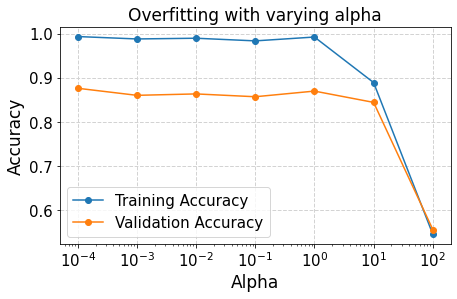

In [105]:
X_val, y_val = X_test, y_test

#hidden layers to try
alphas = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001]

train_acc = []
val_acc = []

for alpha in alphas:
    mlp = MLPClassifier(activation='tanh', alpha=alpha, batch_size=75, early_stopping=True,
                    hidden_layer_sizes=(8), learning_rate='constant',  solver='sgd',
                        max_iter=200, validation_fraction=0.35, random_state=40)
    mlp.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, mlp.predict(X_train)))
    val_acc.append(accuracy_score(y_val, mlp.predict(X_val)))

#Plot
fig, ax = plt.subplots(figsize=(7, 4))

ax.semilogx(alphas, train_acc, '-o', label='Training Accuracy') 
ax.semilogx(alphas, val_acc, '-o', label='Validation Accuracy')

plt.xlabel('Alpha', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.title('Overfitting with varying alpha', fontsize=17)
ax.tick_params(axis='both', labelsize=15)
ax.grid(color='lightgrey', linestyle='--', linewidth=1)
plt.legend(fontsize=15)
plt.show()

### Neural Network, after GridSearch and Hyperparameter tuning

In [44]:
mlp = MLPClassifier(activation='tanh', alpha=10, batch_size=70, early_stopping=True,
                    hidden_layer_sizes=(8), learning_rate='constant',  solver='sgd', validation_fraction=0.35,
                   random_state=42)

#mlp = MLPClassifier()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
mcc = matthews_corrcoef(y_test, y_pred)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print("Matthews'coefficient ", mcc)
print(classification_report(y_test, y_pred))

Accuracy 0.8669871794871795
F1-score [0.87918486 0.85204991]
Matthews'coefficient  0.7322548701970876
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       336
           1       0.88      0.83      0.85       288

    accuracy                           0.87       624
   macro avg       0.87      0.86      0.87       624
weighted avg       0.87      0.87      0.87       624



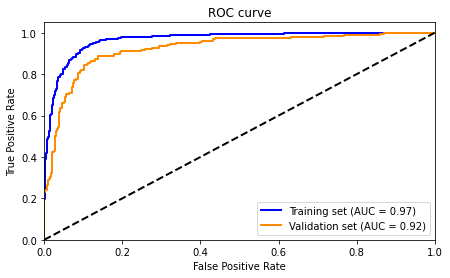

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve

train_probs = mlp.predict_proba(X_train)[:, 1]
val_probs = mlp.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_val, tpr_val, _ = roc_curve(y_test, val_probs)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure(figsize=(7, 4))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Training set (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label='Validation set (AUC = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()